# Numerical example: MCMC from Type Ia Supernovae using the emcee package (Daniela Grandón)


Here we will use actual SNIa data from the JLA compilation [1] to constrain the matter and cosmological-constant energy densities $\Omega_M$ and $\Omega_\Lambda$ in a non-flat universe. To do that we will use emcee [2].

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad # will need for integration ('quadrature')
import emcee
import corner
from multiprocessing import Pool
from pylab import MaxNLocator

### Step 1) Define your model and its dependence on the parameters $\theta$ you want to infer. In this example $\theta$={$\Omega_m$, $\Omega_{\Lambda}$, $M$}

Remember the equation that relates the observed apparent magnitude $m$ and the cosmological parameters is

$m(z) = 5\log_{10} (H_0 d_L(z)) + \mathcal{M}$

In [13]:
"The Hubble function. This equation comes solving the Einstein equations of General Relativity assuming the cosmological principle and the accelerated expansion (The famous FLRW metric)"


def dist_integrand(z, Om, Ok, w):
    Ol = 1 - Om - Ok
    return 1.0/np.sqrt(Om*(1+z)**3 + Ol*(1+z)**(3*(1+w)) + Ok*(1+z)**2)

SMALL = 1.0e-5  # some small number, doesn't matter what

# this is really H0 r(z)!
def rz(z, Om, Ok, w):
    chi = quad(dist_integrand, 0, z, args=(Om, Ok, w))[0]
    if (Ok > SMALL):
        return np.sinh(np.sqrt(Ok)*chi) / np.sqrt(Ok) # open
    elif (Ok < -SMALL):
        return np.sin(np.sqrt(-Ok)*chi) / np.sqrt(-Ok) # closed
    else:
        return chi
    
def dL(z, Om, Ol):
  Ok = 1-Om-Ol # FILL IN HERE
  w = -1.0  # hardcoded; won't change in this exercise
  return (1+z)*rz(z, Om, Ok, w) # FILL IN HERE  # remember our rz is actually H0*r

def m_theory(z, Om, Ol, scriptM):
  return 5*np.log10(dL(z, Om, Ol)) + scriptM

### Step 2) Load up the observed data  

dimensions of data and Cov are (31,) (31, 31)


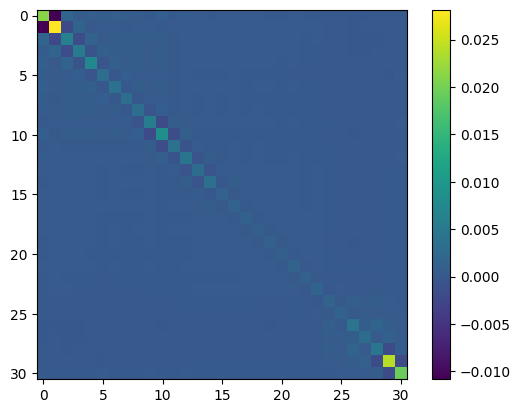

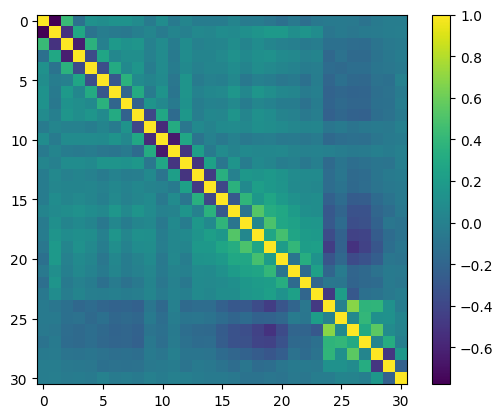

In [2]:
z_obs, m_obs = np.loadtxt("jla_mub.txt").T
C = np.loadtxt("jla_mub_covmax.txt")
C=C.reshape(31,31)
print('dimensions of data and Cov are', z_obs.shape, C.shape)

invC = np.linalg.inv(C)

plt.imshow(C)
plt.colorbar()
plt.show()

plt.imshow(np.corrcoef(C))
plt.colorbar()
plt.show()

### Step 3) Define your likelihood and priors

In [15]:
def lnprior(p):
    Om,Ol,scriptM = p
    if 0 < Ol < 1 and 0 < Om < 1 and 30 < scriptM < 60:
        return 0.0
    return -np.inf

def loglike(p):
    Om, Ol, scriptM = p
    mth_array = [m_theory(z, Om, Ol, scriptM) for z in z_obs]
    d = m_obs - mth_array 
    lnL = -0.5 * d @ invC @ d 
    return lnL

In [17]:
### The log posterior

def lnprob(p):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(p)

### Step 4: Code up emcee

In [18]:
nwalkers=10
ndim=3
nburn=1000
nmcmc=3000
dres=[0.01,0.01,0.01]

/tmp/ipykernel_6051/3581202333.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


MCMC result:
            $\Omega_m$ = 0.19930494834251283 + 0.10688655781396572 -0.10121740634992701 
            $\Omega_\Lambda$    = 0.5589719874168706 + 0.15471983298072578 -0.15755627745564682
            $M$    = 43.16768326122044 + 0.025564924068241623 -0.026045367602129943
        
Mean acceptance fraction: 0.6426333333333333


<Figure size 640x480 with 0 Axes>

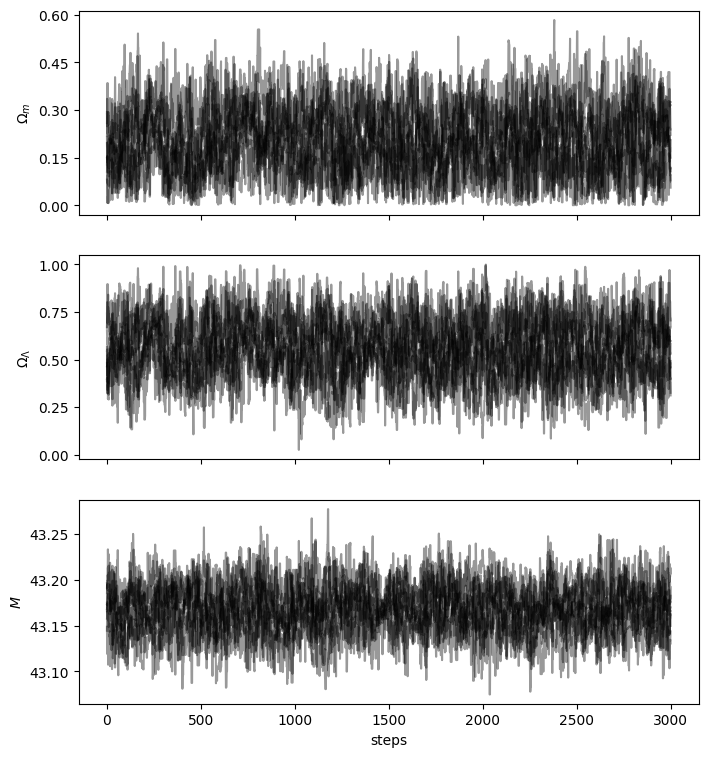

In [19]:
initial_point=np.array([0.3, 0.7, 43.2]) ## initial point


with Pool() as pool:
    pos0 = [initial_point+dres*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)

    pos, prob, state = sampler.run_mcmc(pos0, nburn)

    sampler.reset()
    sampler.run_mcmc(pos, nmcmc)

    plt.clf()
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
    axes[0].yaxis.set_major_locator(MaxNLocator(5))
    axes[0].set_ylabel("$\Omega_m$")

    axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
    axes[1].yaxis.set_major_locator(MaxNLocator(5))
    axes[1].set_ylabel("$\Omega_\Lambda$")

    axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.4)
    axes[2].yaxis.set_major_locator(MaxNLocator(5))
    axes[2].set_ylabel("$M$")

    axes[2].set_xlabel("steps")

    fig.show()
    
    samps = sampler.chain[:, 1:, :].reshape((-1, ndim))
    
    names = [r"$\Omega_m$","$\Omega_\Lambda$",r"$M$"]
    labels = [r"$\Omega_m$","$\Omega_\Lambda$",r"$M$"]

        #samples = MCSamples(samples=samps, names=names, labels=labels)  

    om_mcmc, ol_mcmc, m_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samps, [16, 50, 84],axis=0)))

    print("""MCMC result:
            $\Omega_m$ = {0[0]} + {0[1]} -{0[2]} 
            $\Omega_\Lambda$    = {1[0]} + {1[1]} -{1[2]}
            $M$    = {2[0]} + {2[1]} -{2[2]}
        """.format(om_mcmc, ol_mcmc, m_mcmc))

    print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
        
samples = sampler.chain[:, 1:, :].reshape((-1, ndim))
        

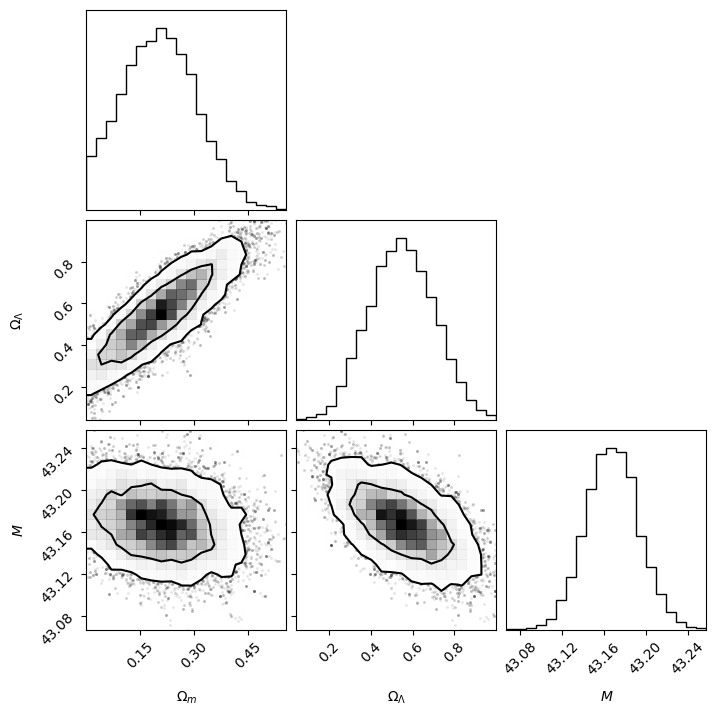

In [8]:
fig = corner.corner(samples,labels=labels,levels=(0.68,0.95))#,range=[(0.18,0.33),(-1.12,-0.95),(0.72,0.87)])
plt.show()

### References
[1] Betoule et al. 2014 https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract

[2] https://emcee.readthedocs.io/en/stable/